In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from transforms3d.euler import mat2euler

def load_data(file_name):
    '''
    function to read visual features, IMU measurements and calibration parameters
    Input:
        file_name: the input data file. Should look like "XX.npz"
    Output:
        t: time stamp
            with shape 1*t
        features: visual feature point coordinates in stereo images, 
            with shape 4*n*t, where n is number of features
        linear_velocity: velocity measurements in IMU frame
            with shape 3*t
        angular_velocity: angular velocity measurements in IMU frame
            with shape 3*t
        K: (left)camera intrinsic matrix
            with shape 3*3
        b: stereo camera baseline
            with shape 1
        imu_T_cam: extrinsic matrix from (left)camera to imu, in SE(3).
            with shape 4*4
    '''
    with np.load(file_name) as data:
    
        t = data["time_stamps"] # time_stamps
        features = data["features"] # 4 x num_features : pixel coordinates of features
        linear_velocity = data["linear_velocity"] # linear velocity measured in the body frame
        angular_velocity = data["angular_velocity"] # angular velocity measured in the body frame
        K = data["K"] # intrindic calibration matrix
        b = data["b"] # baseline
        imu_T_cam = data["imu_T_cam"] # Transformation from left camera to imu frame 
    
    return t,features,linear_velocity,angular_velocity,K,b,imu_T_cam

def parse_data(data):
    '''
    Utility function to parse the npy file
    '''
    ang_vel = data[3]
    lin_vel = data[2]
    features = data[1]
    TS = data[0]
    imu_T_cam = data[-1]
    K = data[-3]
    b = data[-2]
    return ang_vel, lin_vel, features, TS, imu_T_cam, K, b

def load_data_from_dir(dir_name):
    '''
    function to read visual features, IMU measurements and calibration parameters
    Input:
        file_name: the input data file. Should look like "XX.npz"
    Output:
        t: time stamp
            with shape 1*t
        features: visual feature point coordinates in stereo images, 
            with shape 4*n*t, where n is number of features
        linear_velocity: velocity measurements in IMU frame
            with shape 3*t
        angular_velocity: angular velocity measurements in IMU frame
            with shape 3*t
        K: (left)camera intrinsic matrix
            with shape 3*3
        b: stereo camera baseline
            with shape 1
        imu_T_cam: extrinsic matrix from (left)camera to imu, in SE(3).
            with shape 4*4
    '''
    
    data = {}
    
    file_list = os.listdir(dir_name)
    for file in file_list:
        print(os.path.join(dir_name, file))
        data[file[:-4]] = np.load(os.path.join(dir_name, file))
    
    return data


def visualize_trajectory_2d(pose, mean = None, path_name="Path update after EKF",show_ori=False):
    '''
    function to visualize the trajectory in 2D
    Input:
        pose:   4*4*N matrix representing the camera pose, 
                where N is the number of poses, and each
                4*4 matrix is in SE(3)
    '''
    fig,ax = plt.subplots(figsize=(5,5))
    n_pose = pose.shape[2]
    ax.plot(pose[0,3,:],pose[1,3,:],'r-',label=path_name)
    ax.scatter(pose[0,3,0],pose[1,3,0],marker='s',label="start")
    ax.scatter(pose[0,3,-1],pose[1,3,-1],marker='o',label="end")
    if mean is not None:
        ax.scatter(mean[0,:],mean[1,:],s = 2,label="landmark")
  
    if show_ori:
        select_ori_index = list(range(0,n_pose,max(int(n_pose/50), 1)))
        yaw_list = []
        
        for i in select_ori_index:
            _,_,yaw = mat2euler(pose[:3,:3,i])
            yaw_list.append(yaw)
    
        dx = np.cos(yaw_list)
        dy = np.sin(yaw_list)
        dx,dy = [dx,dy]/np.sqrt(dx**2+dy**2)
        ax.quiver(pose[0,3,select_ori_index],pose[1,3,select_ori_index],dx,dy,\
            color="b",units="xy",width=1)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('equal')
    ax.grid(False)
    ax.legend()
    plt.savefig('test.jpeg')
    plt.show(block=True)

    return fig, ax
def visualize_trajectory_2d_imu(pose, mean = None, path_name="IMU by EKF",show_ori=False):
    '''
    function to visualize the trajectory in 2D
    Input:
        pose:   4*4*N matrix representing the camera pose, 
                where N is the number of poses, and each
                4*4 matrix is in SE(3)
    '''
    fig,ax = plt.subplots(figsize=(5,5))
    n_pose = pose.shape[2]
    ax.plot(pose[0,3,:],pose[1,3,:],'r-',label=path_name)
    ax.scatter(pose[0,3,0],pose[1,3,0],marker='s',label="start")
    ax.scatter(pose[0,3,-1],pose[1,3,-1],marker='o',label="end")
    if mean is not None:
        ax.scatter(mean[0,:],mean[1,:],s = 2,label="landmark")
  
    if show_ori:
        select_ori_index = list(range(0,n_pose,max(int(n_pose/50), 1)))
        yaw_list = []
        
        for i in select_ori_index:
            _,_,yaw = mat2euler(pose[:3,:3,i])
            yaw_list.append(yaw)
    
        dx = np.cos(yaw_list)
        dy = np.sin(yaw_list)
        dx,dy = [dx,dy]/np.sqrt(dx**2+dy**2)
        ax.quiver(pose[0,3,select_ori_index],pose[1,3,select_ori_index],dx,dy,\
            color="b",units="xy",width=1)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('equal')
    ax.grid(False)
    ax.legend()
    plt.savefig('test.jpeg')
    plt.show(block=True)

    return fig, ax

def get_features_current_frame(features, idx, K=10):
    '''
    Retrieves features from the current frame at the given time index.
    Returns a 3xM array where invalid points are marked with NaN.
    '''
    current_features = features[:, :, idx]
    
    # Assign NaN to invalid feature points
    current_features[:, current_features[0, :] < 0] = np.nan
    # Downsample the features by selecting every Kth point
    downsampled_features = current_features[:, : -1 : K]
    valid_features_indices = np.where(~np.isnan(downsampled_features[0, :]))
    
    return downsampled_features, valid_features_indices[0].tolist()

def get_idx(listA, list_global):
    '''
    Identifies indices in listA that are also in list_global,
    and indices that are unique to listA.
    '''
    existing_indices = []
    new_indices = []
    for element in listA:
        if element in list_global:
            existing_indices.append(element)
        else:
            new_indices.append(element)
    
    return existing_indices, new_indices

def hat(vector):
    '''
    Generates a skew-symmetric matrix from a 3-dimensional vector.
    '''
    assert vector.shape[0] == 3, 'Expected a 3D vector for skew-symmetric conversion.'
    
    skew_matrix = np.array([[0, -vector[2], vector[1]],
                            [vector[2], 0, -vector[0]],
                            [-vector[1], vector[0], 0]])
    
    return skew_matrix

def hat_alt(vector):
    '''
    Creates an extended skew-symmetric matrix from a 6-dimensional vector.
    '''
    assert vector.shape[0] == 6, 'Expected a 6D vector for extended skew-symmetric conversion.'
    
    primary_skew = hat(vector[:3])
    secondary_skew = hat(vector[3:])
    
    combined_matrix = np.vstack((
        np.hstack((secondary_skew, primary_skew)),
        np.hstack((np.zeros((3, 3)), secondary_skew))
    ))
    return combined_matrix

def twist_matrix(vector):
    '''
    Constructs a twist matrix from a 6-dimensional vector.
    '''
    assert vector.shape[0] == 6, 'Expected a 6D vector for twist matrix creation.'
    twist_mat = np.vstack((
        np.column_stack((hat(vector[3:]), vector[:3])),
        np.zeros((1, 4))
    ))
    return twist_mat

def Homogenize(points):
    '''
    Converts points from inhomogeneous to homogeneous coordinates.
    '''
    return np.vstack((points, np.ones((1, points.shape[1]))))

def Dehomogenize(points):
    '''
    Converts points from homogeneous back to inhomogeneous coordinates.
    '''
    return points[:-1] / points[-1]

if __name__ == "__main__":
  print("proceeding")

proceeding


In [8]:


import numpy as np
# from pr3_utils import Homogenize, Dehomogenize, hat



def translate_to_camera(x_w, w_T_imu, imu_T_cam, Ks):
    '''
    Translates the landmark coordinates in world frame to the
    left image pixel coordinates
    '''
# Validate the input shape for world coordinates
    assert x_w.shape[0] == 3, 'Expected an array of 3xN world points'
    # Transform from world coordinates to camera coordinates
    camera_coordinates = np.linalg.inv(w_T_imu @ imu_T_cam) @ Homogenize(x_w)

    # Project camera coordinates to image pixels
    pixel_coordinates = Ks @ (camera_coordinates / camera_coordinates[2, :])
    return pixel_coordinates
def compute_jacobian(camera_matrix, world_to_imu, imu_to_cam, world_points, idxs):
    '''
    Function to compute the Jacobian of the observation model wrt landmark points
    '''
    num_obs = len(idxs)
    num_points = world_points.shape[1]
    imu_to_world = np.linalg.inv(world_to_imu @ imu_to_cam)
    points_in_cam = imu_to_world @ Homogenize(world_points)
    jacobian_matrix = np.zeros((4*num_obs,3*num_points))
    cam_projection = np.hstack((np.eye(3), np.zeros((3,1))))
    for i in range(num_obs):
        landmark_idx = idxs[i]
        jacobian_matrix[4*i:4*i+4,3*landmark_idx:3*landmark_idx+3] = camera_matrix @ projection_function(points_in_cam[:,landmark_idx]) @ imu_to_world @ cam_projection.T
    return jacobian_matrix


def projection_function(q):
    '''
    Compute the derivative of the projection function
    at q
    '''
# Unpack the components of vector q
    q1, q2, q3, q4 = q

    # Compute the derivative matrix
    derivative_matrix = np.array([
        [1, 0, -q1 / q3, 0],
        [0, 1, -q2 / q3, 0],
        [0, 0, 0, 0],
        [0, 0, -q4 / q3, 1]
    ]) / q3

    return derivative_matrix

def translate_to_world(features, w_T_imu, imu_T_cam, K, b):
    '''
    Utility function translates features in image coordinate to 
    the world frame.
    '''
# Calculate depth from stereo disparity
    depth = (K[0,0] * b) / (features[0, :] - features[2, :])
    # Determine Y and X coordinates from depth and intrinsic parameters
    y_coord = depth * (features[1, :] - K[1,2]) / K[1,1]
    x_coord = depth * (features[0, :] - K[0,2]) / K[0,0]

    # Convert the coordinates into homogeneous form
    homogeneous_camera_coords = Homogenize(np.vstack((x_coord, y_coord, depth)))
    # Transform coordinates from camera to IMU frame
    imu_frame_coords = imu_T_cam @ homogeneous_camera_coords
    # Transform coordinates from IMU to world frame and dehomogenize
    world_frame_coords = Dehomogenize(w_T_imu @ imu_frame_coords)
    return world_frame_coords

def observation_model(s):
    '''
    Utility function to compute the dot operator for jacobian of observation model wrt map co-ord
    '''
    # Ensure the input is in 4D homogeneous format
    assert s.shape[0] == 4, 'Expected 4D homogeneous coordinates'
    # Normalize the vector
    normalized_s = s / s[-1]

    # Construct the matrix with skew-symmetric part for normalized vector
    transform_matrix = np.vstack((
        np.hstack((np.eye(3), -hat(normalized_s[:3]))),
        np.zeros((1, 6))
    ))
    return transform_matrix


IMU Localization

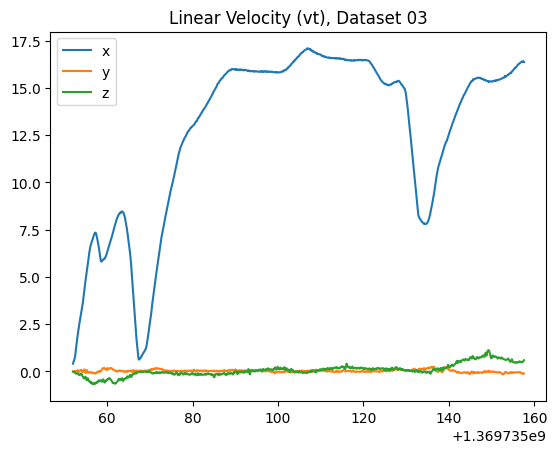

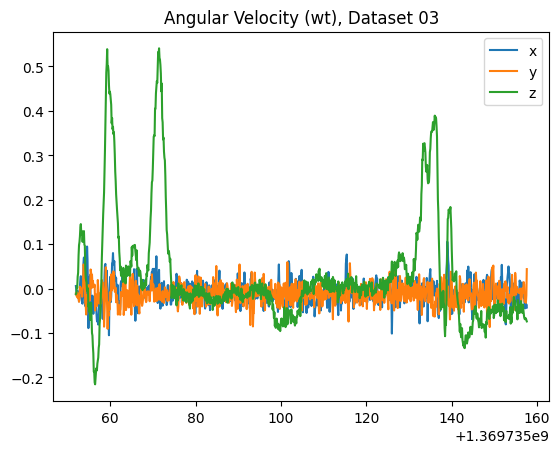

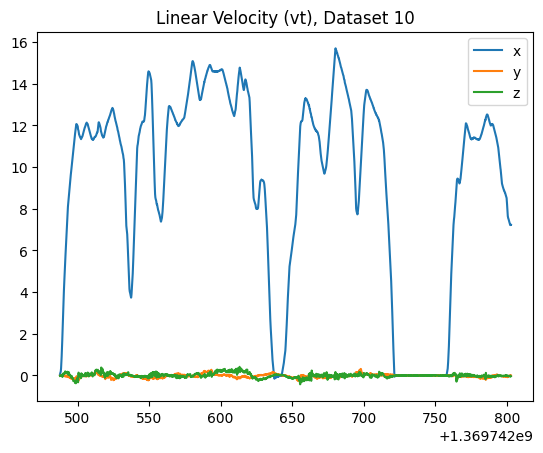

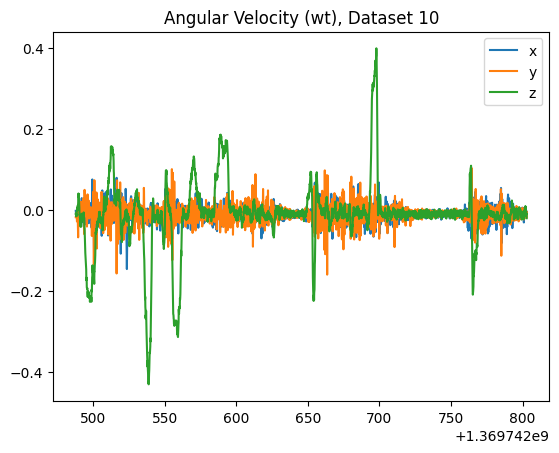

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from transforms3d.euler import mat2euler
from pr3_utils import *
from tqdm.notebook import tqdm
import scipy
DATASET = "03"
# Load the measurements
filename = f'/Users/sreebhargavibalija/Documents/ECE276A_PR3_ucsd 2/data/03.npz'
t,features,linear_velocity,angular_velocity,K,b,imu_T_cam = load_data(filename)
t = np.squeeze(t,0)

features = features[:,::2,:]
fsu, fsth, cu, fsv, cv = K[0,0], K[0,1], K[0,2], K[1,1], K[1,2]

Ks = np.array([[fsu,0,cu,0],
               [0,fsv,cv,0],
               [fsu,0,cu,-fsu*b],
               [0,fsv,cv,0]])

np.tile(t,(3,1)).shape

plt.plot(np.tile(t,(3,1)).T,linear_velocity.T)
plt.title(f'Linear Velocity (vt), Dataset {DATASET}')
plt.legend(['x','y','z'])
plt.show()
plt.plot(np.tile(t,(3,1)).T,angular_velocity.T)
plt.title(f'Angular Velocity (wt), Dataset {DATASET}')
plt.legend(['x','y','z'])
plt.show()
DATASET = "10"
# Load the measurements
filename = f'/Users/sreebhargavibalija/Documents/ECE276A_PR3_ucsd 2/data/10.npz'
t,features,linear_velocity,angular_velocity,K,b,imu_T_cam = load_data(filename)
t = np.squeeze(t,0)

features = features[:,::2,:]
fsu, fsth, cu, fsv, cv = K[0,0], K[0,1], K[0,2], K[1,1], K[1,2]

Ks = np.array([[fsu,0,cu,0],
               [0,fsv,cv,0],
               [fsu,0,cu,-fsu*b],
               [0,fsv,cv,0]])

np.tile(t,(3,1)).shape

plt.plot(np.tile(t,(3,1)).T,linear_velocity.T)
plt.title(f'Linear Velocity (vt), Dataset {DATASET}')
plt.legend(['x','y','z'])
plt.show()

plt.plot(np.tile(t,(3,1)).T,angular_velocity.T)
plt.title(f'Angular Velocity (wt), Dataset {DATASET}')
plt.legend(['x','y','z'])
plt.show()



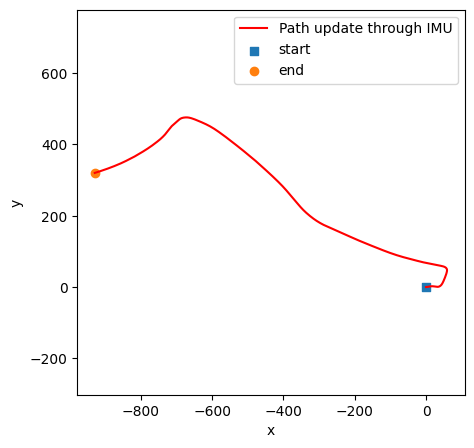

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

In [5]:

"""
a) Implementing   the  IMU localization based on SE(3)\kinematics using the linear and angular velocity measurements.
"""
import numpy as np
# from pr3_utils import *
from scipy.linalg import expm

data = load_data('/Users/sreebhargavibalija/Documents/ECE276A_PR3_ucsd 2/data/03.npz')
pose = np.eye(4)
pose_toplot = pose
ang_vel, lin_vel, _, timestamp, _, _, _ = parse_data(data)
prev_t = timestamp[0,0]

for index in range(1, lin_vel.shape[1]):
    omega = ang_vel[:, index]
    velocity = lin_vel[:, index]
    twist_matrix = np.array([[0, -omega[2], omega[1], velocity[0]],
                             [omega[2], 0, -omega[0], velocity[1]],
                             [-omega[1], omega[0], 0, velocity[2]],
                             [0, 0, 0, 0]])
    
    pose = pose @ expm(twist_matrix * (timestamp[0, index] - prev_t))
    prev_t = timestamp[0, index]
    pose_toplot = np.dstack((pose_toplot, pose))

visualize_trajectory_2d_imu(pose_toplot)


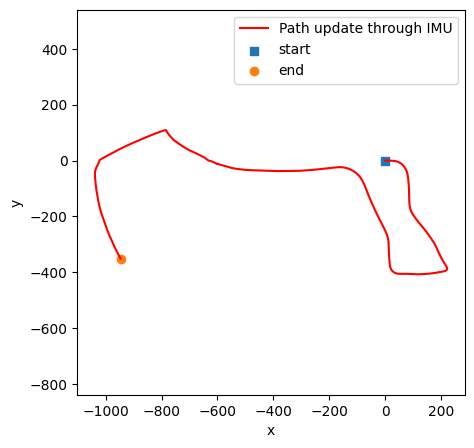

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

In [4]:

"""
a) Implementing   the  IMU localization based on SE(3)\kinematics using the linear and angular velocity measurements.
"""
import numpy as np
# from pr3_utils import *
from scipy.linalg import expm

data = load_data('/Users/sreebhargavibalija/Documents/ECE276A_PR3_ucsd 2/data/10.npz')
pose = np.eye(4)
pose_toplot = pose
ang_vel, lin_vel, _, timestamp, _, _, _ = parse_data(data)
prev_t = timestamp[0,0]

for index in range(1, lin_vel.shape[1]):
    omega = ang_vel[:, index]
    velocity = lin_vel[:, index]
    twist_matrix = np.array([[0, -omega[2], omega[1], velocity[0]],
                             [omega[2], 0, -omega[0], velocity[1]],
                             [-omega[1], omega[0], 0, velocity[2]],
                             [0, 0, 0, 0]])
    
    pose = pose @ expm(twist_matrix * (timestamp[0, index] - prev_t))
    prev_t = timestamp[0, index]
    pose_toplot = np.dstack((pose_toplot, pose))

visualize_trajectory_2d_imu(pose_toplot)


Landmark mapping

100%|██████████| 1009/1009 [00:28<00:00, 35.23it/s]


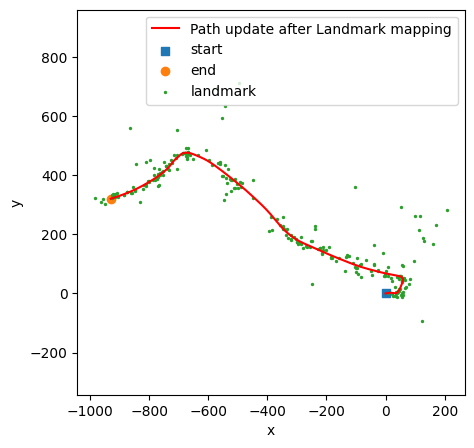

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

In [1]:

import numpy as np
from scipy.linalg import expm
from tqdm import tqdm

    
sensor_data = load_data('/Users/sreebhargavibalija/Documents/ECE276A_PR3_ucsd 2/data/03.npz')
angular_velocity, linear_velocity, landmarks_obs, time_stamps, cam_transform, stereo_params, stereo_baseline = parse_data(sensor_data)
camera_matrix_stereo = np.vstack((stereo_params[:2,:],stereo_params[:2,:]))
camera_matrix_stereo = np.hstack((camera_matrix_stereo, np.zeros((4,1))))
camera_matrix_stereo[2,-1] = - camera_matrix_stereo[0,0]*stereo_baseline
current_pose = np.eye(4)
last_time_stamp = time_stamps[0,0]
pose_history = current_pose
init_landmarks, observed_lm_indices = get_features_current_frame(landmarks_obs, 0, 20)
world_landmarks = translate_to_world(init_landmarks, current_pose, cam_transform, stereo_params, stereo_baseline)
num_landmarks = init_landmarks.shape[1]
lmean = np.ones((3,num_landmarks))*np.nan
covariance = np.zeros((3*num_landmarks,3*num_landmarks))

for index in range(len(observed_lm_indices)):
    landmark_id = observed_lm_indices[index]
    lmean[:, landmark_id] = world_landmarks[:, landmark_id]
    covariance[3 * landmark_id:3 * (landmark_id + 1), 3 * landmark_id:3 * (landmark_id + 1)] = np.eye(3)

measurement_noise = 0.5 * np.eye(4)


# Main processing loop
for idx in tqdm(range(1, linear_velocity.shape[1])):
    time_step = time_stamps[0, idx] - last_time_stamp
    last_time_stamp = time_stamps[0, idx]
    rot_vel = angular_velocity[:, idx]
    trans_vel = linear_velocity[:, idx]
    motion_update = twist_matrix(np.hstack((trans_vel, rot_vel)))
    current_pose = current_pose @ expm(motion_update * time_step)
    pose_history = np.dstack((pose_history, current_pose))
    observed_landmarks_current, valid_landmark_indices = get_features_current_frame(landmarks_obs, idx, 20)
    update_indices, add_indices = get_idx(valid_landmark_indices, observed_lm_indices)

    # update_indices, add_indices = get_idx(valid_lm_indices, observed_lm_indices)
    
    # Perform updates
    if update_indices:
        # Calculate the Jacobian based on current states and observed landmarks.
        jacobian_matrix = compute_jacobian(camera_matrix_stereo, current_pose, cam_transform, lmean, update_indices)
        # Compute the Kalman gain using the current covariance and Jacobian.
        gain_kalman = covariance @ jacobian_matrix.T @ np.linalg.inv(jacobian_matrix @ covariance @ jacobian_matrix.T + np.kron(np.eye(len(update_indices)), measurement_noise))
        
        # Compute the difference between observed and expected landmark positions.
        observation_error = observed_landmarks_current[:, update_indices] - translate_to_camera(lmean[:, update_indices], current_pose, cam_transform, camera_matrix_stereo)
        # Update the mean state of landmarks based on observation error and Kalman gain.
        mean_update = gain_kalman @ observation_error.ravel('F')
        lmean[:, update_indices] += mean_update.reshape(3, -1, order='F')[:, update_indices]
        
        # Update the covariance matrix based on the Jacobian and Kalman gain.
        covariance -= gain_kalman @ jacobian_matrix @ covariance

        
    if add_indices:
        converted_landmarks = translate_to_world(observed_landmarks_current, current_pose, cam_transform, stereo_params, stereo_baseline)
        
        for idx in add_indices:
            updated_index = idx
            lmean[:, updated_index] = converted_landmarks[:, updated_index]
            covariance[3 * updated_index : 3 * (updated_index + 1), 3 * updated_index : 3 * (updated_index + 1)] = np.identity(3)
            observed_lm_indices.append(updated_index)


visualize_trajectory_2d(pose_history, lmean)


100%|██████████| 3025/3025 [12:53<00:00,  3.91it/s]


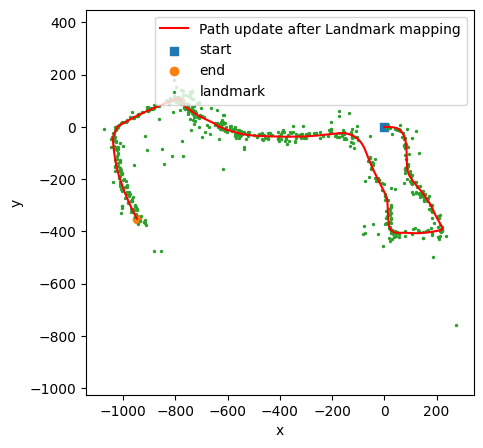

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

In [11]:

import numpy as np
from scipy.linalg import expm
from tqdm import tqdm

    
sensor_data = load_data('/Users/sreebhargavibalija/Documents/ECE276A_PR3_ucsd 2/data/10.npz')
angular_velocity, linear_velocity, landmarks_obs, time_stamps, cam_transform, stereo_params, stereo_baseline = parse_data(sensor_data)
camera_matrix_stereo = np.vstack((stereo_params[:2,:],stereo_params[:2,:]))
camera_matrix_stereo = np.hstack((camera_matrix_stereo, np.zeros((4,1))))
camera_matrix_stereo[2,-1] = - camera_matrix_stereo[0,0]*stereo_baseline
current_pose = np.eye(4)
last_time_stamp = time_stamps[0,0]
pose_history = current_pose
init_landmarks, observed_lm_indices = get_features_current_frame(landmarks_obs, 0, 20)
world_landmarks = translate_to_world(init_landmarks, current_pose, cam_transform, stereo_params, stereo_baseline)
num_landmarks = init_landmarks.shape[1]
lmean = np.ones((3,num_landmarks))*np.nan
covariance = np.zeros((3*num_landmarks,3*num_landmarks))

for index in range(len(observed_lm_indices)):
    landmark_id = observed_lm_indices[index]
    lmean[:, landmark_id] = world_landmarks[:, landmark_id]
    covariance[3 * landmark_id:3 * (landmark_id + 1), 3 * landmark_id:3 * (landmark_id + 1)] = np.eye(3)

measurement_noise = 0.5 * np.eye(4)


# Main processing loop
for idx in tqdm(range(1, linear_velocity.shape[1])):
    time_step = time_stamps[0, idx] - last_time_stamp
    last_time_stamp = time_stamps[0, idx]
    rot_vel = angular_velocity[:, idx]
    trans_vel = linear_velocity[:, idx]
    motion_update = twist_matrix(np.hstack((trans_vel, rot_vel)))
    current_pose = current_pose @ expm(motion_update * time_step)
    pose_history = np.dstack((pose_history, current_pose))
    observed_landmarks_current, valid_landmark_indices = get_features_current_frame(landmarks_obs, idx, 20)
    update_indices, add_indices = get_idx(valid_landmark_indices, observed_lm_indices)

    # update_indices, add_indices = get_idx(valid_lm_indices, observed_lm_indices)
    
    # Perform updates
    if update_indices:
        # Calculate the Jacobian based on current states and observed landmarks.
        jacobian_matrix = compute_jacobian(camera_matrix_stereo, current_pose, cam_transform, lmean, update_indices)
        # Compute the Kalman gain using the current covariance and Jacobian.
        gain_kalman = covariance @ jacobian_matrix.T @ np.linalg.inv(jacobian_matrix @ covariance @ jacobian_matrix.T + np.kron(np.eye(len(update_indices)), measurement_noise))
        
        # Compute the difference between observed and expected landmark positions.
        observation_error = observed_landmarks_current[:, update_indices] - translate_to_camera(lmean[:, update_indices], current_pose, cam_transform, camera_matrix_stereo)
        # Update the mean state of landmarks based on observation error and Kalman gain.
        mean_update = gain_kalman @ observation_error.ravel('F')
        lmean[:, update_indices] += mean_update.reshape(3, -1, order='F')[:, update_indices]
        
        # Update the covariance matrix based on the Jacobian and Kalman gain.
        covariance -= gain_kalman @ jacobian_matrix @ covariance

        
    if add_indices:
        converted_landmarks = translate_to_world(observed_landmarks_current, current_pose, cam_transform, stereo_params, stereo_baseline)
        
        for idx in add_indices:
            updated_index = idx
            lmean[:, updated_index] = converted_landmarks[:, updated_index]
            covariance[3 * updated_index : 3 * (updated_index + 1), 3 * updated_index : 3 * (updated_index + 1)] = np.identity(3)
            observed_lm_indices.append(updated_index)


visualize_trajectory_2d(pose_history, lmean)


Visual slam

In [ ]:
def jacob(Ks, w_T_imu, imu_T_cam, x_w, idx_list):
    '''
    Helper function to compute the Jacobian of the observation 
    model wrt to landmark points
    '''
    N = len(idx_list)
    M = x_w.shape[1]
    cam_T_w = np.linalg.inv(w_T_imu @ imu_T_cam)
    cam_T_imu = np.linalg.inv(imu_T_cam)
    imu_T_w = np.linalg.inv(w_T_imu)
    x_cam = cam_T_w @ Homogenize(x_w)
    x_imu = imu_T_w @ Homogenize(x_w)
    
    H = np.zeros((4*N,3*M+6))
    P = np.hstack((np.eye(3), np.zeros((3,1))))
    for i in range(N):
        idx = idx_list[i]
        H[4*i:4*i+4,3*idx:3*idx+3] = Ks @ dpi_dq(x_cam[:,idx]) @ cam_T_w @ P.T
        H[4*i:4*i+4,-6:] = -Ks @ dpi_dq(x_cam[:,idx]) @ cam_T_imu  @ dot_op(x_imu[:,idx])
    return H


100%|██████████| 1009/1009 [01:19<00:00, 12.65it/s]


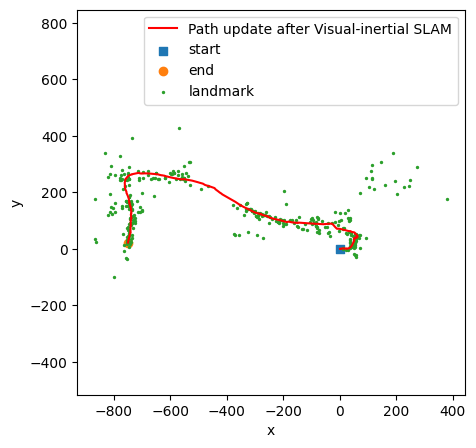

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

In [12]:

import numpy as np
from pr3_utils import *
from cam_utils import *
from scipy.linalg import expm
from tqdm import tqdm

    
data = load_data('/Users/sreebhargavibalija/Desktop/ECE-276A/PR3/data/03.npz')
feature_skip = 15

# Read Data
ang_vel, lin_vel, features, TS, imu_T_cam, K, b = parse_data(data)

# Stereo camera matrix
Ks = np.vstack((K[:2,:],K[:2,:]))
Ks = np.hstack((Ks, np.zeros((4,1))))
Ks[2,-1] = - Ks[0,0]*b

# init pose 
mean_pose = expm(twist_matrix(np.array([0,0,0,np.pi,0,0]))) #np.eye(4)

# Cache last time stamp
prev_TS = TS[0,0]

# Placeholder to store pose of the robot
pose_toplot = mean_pose

# Read features
curr_features,detected_LM_idx = get_features_current_frame(features, 0, feature_skip)

# Translate image features to world coordinates
x_w_landmark = translate_to_world(curr_features, mean_pose, imu_T_cam, K, b)

# Number of landmarks
M = curr_features.shape[1]

# Init mean and cov
mean_L = np.ones((3,M))*np.nan
cov = np.zeros((3*M+6,3*M+6))

mean_L[:,detected_LM_idx] = x_w_landmark[:,detected_LM_idx]
cov[-6:,-6:] = np.eye(6)
for i in range(len(detected_LM_idx)):
    idx = detected_LM_idx[i]
    cov[3*idx:3*idx+3,3*idx:3*idx+3] = np.eye(3)
    
# Initalize noises
# Measurement noise
V = np.eye(4)*10

# Motion noise
W = np.eye(6)
W[0:3,0:3] = W[0:3,0:3]*1#0.3
W[3:6,3:6] = W[3:6,3:6]*0.3#0.05

###### Loop over time #######
for fIdx in tqdm(range(1,lin_vel.shape[1])):
    
    # Manage time
    tau = TS[0,fIdx]-prev_TS
    prev_TS = TS[0,fIdx]
    
    w = ang_vel[:,fIdx]
    w[-1] = -w[-1]
    v = lin_vel[:,fIdx]
     
    # Get twist matix for motion model
    tm = twist_matrix(np.hstack((v,w)))
    
    # Mean pose predict
    mean_pose = mean_pose @ expm(tm*tau)    
    
    # Cov pose predict
    F = expm(-tau*hat_alt(np.hstack((v,w))))
    cov[-6:,-6:] = F @ cov[-6:,-6:] @ F.T + W
        
    # Featch image features
    curr_features,valid_landmarks = get_features_current_frame(features, fIdx, feature_skip)
    
    # Get feature idx to update and add
    idx_toUpdate, idx_toAdd = get_idx(valid_landmarks, detected_LM_idx)
    
    # Update
    if len(idx_toUpdate) > 0:
        # Compute Jacobian
        H = jacob(Ks, mean_pose, imu_T_cam, mean_L, idx_toUpdate)

        # Compute Kalman Gain
        KG = cov @ H.T @ np.linalg.inv(H @ cov @ H.T + np.kron(np.eye(len(idx_toUpdate)),V))
        
        # Mean update
        res = curr_features[:, idx_toUpdate] - translate_to_camera(mean_L[:,idx_toUpdate], mean_pose, imu_T_cam, Ks)
        delta_mean = KG @  res.ravel('F')
        
        # landmark pos update
        delta_mean_L = delta_mean[:-6].reshape(3,-1, order = 'F')
        mean_L[:,idx_toUpdate] = mean_L[:,idx_toUpdate] + delta_mean_L[:,idx_toUpdate]
        
        # mean pose update
        delta_mean_pose = delta_mean[-6:]
        mean_pose = mean_pose @ expm(twist_matrix(delta_mean_pose))

        t1 = (np.eye(3*M + 6) - KG @ H)
        cov = t1 @ cov @ t1.T + KG @ np.kron(np.eye(len(idx_toUpdate)),V) @ KG.T

    if len(idx_toAdd) > 0:
        x_w_landmark = translate_to_world(curr_features, mean_pose, imu_T_cam, K, b)
        mean_L[:,idx_toAdd] = x_w_landmark[:,idx_toAdd]
        for j in range(len(idx_toAdd)):
            idx = idx_toAdd[j]
            cov[3*idx:3*idx+3,3*idx:3*idx+3] = np.eye(3)
            detected_LM_idx.append(idx)
            
    # Save pose 
    pose_toplot = np.dstack((pose_toplot, mean_pose))
    
visualize_trajectory_2d_slam(pose_toplot, mean_L)



In [ ]:

import numpy as np
from pr3_utils import *
from cam_utils import *
from scipy.linalg import expm
from tqdm import tqdm

    
data = load_data('/Users/sreebhargavibalija/Desktop/ECE-276A/PR3/data/10.npz')
feature_skip = 15

# Read Data
ang_vel, lin_vel, features, TS, imu_T_cam, K, b = parse_data(data)

# Stereo camera matrix
Ks = np.vstack((K[:2,:],K[:2,:]))
Ks = np.hstack((Ks, np.zeros((4,1))))
Ks[2,-1] = - Ks[0,0]*b

# init pose 
mean_pose = expm(twist_matrix(np.array([0,0,0,np.pi,0,0]))) #np.eye(4)

# Cache last time stamp
prev_TS = TS[0,0]

# Placeholder to store pose of the robot
pose_toplot = mean_pose

# Read features
curr_features,detected_LM_idx = get_features_current_frame(features, 0, feature_skip)

# Translate image features to world coordinates
x_w_landmark = translate_to_world(curr_features, mean_pose, imu_T_cam, K, b)

# Number of landmarks
M = curr_features.shape[1]

# Init mean and cov
mean_L = np.ones((3,M))*np.nan
cov = np.zeros((3*M+6,3*M+6))

mean_L[:,detected_LM_idx] = x_w_landmark[:,detected_LM_idx]
cov[-6:,-6:] = np.eye(6)
for i in range(len(detected_LM_idx)):
    idx = detected_LM_idx[i]
    cov[3*idx:3*idx+3,3*idx:3*idx+3] = np.eye(3)
    
# Initalize noises
# Measurement noise
V = np.eye(4)*10

# Motion noise
W = np.eye(6)
W[0:3,0:3] = W[0:3,0:3]*1#0.3
W[3:6,3:6] = W[3:6,3:6]*0.3#0.05

###### Loop over time #######
for fIdx in tqdm(range(1,lin_vel.shape[1])):
    
    # Manage time
    tau = TS[0,fIdx]-prev_TS
    prev_TS = TS[0,fIdx]
    
    w = ang_vel[:,fIdx]
    w[-1] = -w[-1]
    v = lin_vel[:,fIdx]
     
    # Get twist matix for motion model
    tm = twist_matrix(np.hstack((v,w)))
    
    # Mean pose predict
    mean_pose = mean_pose @ expm(tm*tau)    
    
    # Cov pose predict
    F = expm(-tau*hat_alt(np.hstack((v,w))))
    cov[-6:,-6:] = F @ cov[-6:,-6:] @ F.T + W
        
    # Featch image features
    curr_features,valid_landmarks = get_features_current_frame(features, fIdx, feature_skip)
    
    # Get feature idx to update and add
    idx_toUpdate, idx_toAdd = get_idx(valid_landmarks, detected_LM_idx)
    
    # Update
    if len(idx_toUpdate) > 0:
        # Compute Jacobian
        H = jacob(Ks, mean_pose, imu_T_cam, mean_L, idx_toUpdate)

        # Compute Kalman Gain
        KG = cov @ H.T @ np.linalg.inv(H @ cov @ H.T + np.kron(np.eye(len(idx_toUpdate)),V))
        
        # Mean update
        res = curr_features[:, idx_toUpdate] - translate_to_cam(mean_L[:,idx_toUpdate], mean_pose, imu_T_cam, Ks)
        delta_mean = KG @  res.ravel('F')
        
        # landmark pos update
        delta_mean_L = delta_mean[:-6].reshape(3,-1, order = 'F')
        mean_L[:,idx_toUpdate] = mean_L[:,idx_toUpdate] + delta_mean_L[:,idx_toUpdate]
        
        # mean pose update
        delta_mean_pose = delta_mean[-6:]
        mean_pose = mean_pose @ expm(twist_matrix(delta_mean_pose))

        t1 = (np.eye(3*M + 6) - KG @ H)
        cov = t1 @ cov @ t1.T + KG @ np.kron(np.eye(len(idx_toUpdate)),V) @ KG.T

    if len(idx_toAdd) > 0:
        x_w_landmark = translate_to_world(curr_features, mean_pose, imu_T_cam, K, b)
        mean_L[:,idx_toAdd] = x_w_landmark[:,idx_toAdd]
        for j in range(len(idx_toAdd)):
            idx = idx_toAdd[j]
            cov[3*idx:3*idx+3,3*idx:3*idx+3] = np.eye(3)
            detected_LM_idx.append(idx)
            
    # Save pose 
    pose_toplot = np.dstack((pose_toplot, mean_pose))
    
visualize_trajectory_2d_slam(pose_toplot, mean_L)
